## GOES XRS Comparisons

Compare overlapping xray observations for GOES 8 through 18.
- Determin how well the fluxes match by fitting a line to pairs
    - Nominal Slope: 1
    - Nominal Intercept: 0

Identify which pairs most closely match to GOES R-Series (16,17,18). These satellites can be used to train with real-time data for one an operational models. 

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import glob
from itertools import combinations

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


In [3]:
# satellites we are working with
sat = [f'g{x:02}' for x in np.arange(8,19)]
# columns we are interested in comparing
gcol = ['xrsa_flux','xrsb_flux']

# data dir
d_dir = "D:/data/GOES/XRS/"
# dictionary for data 
dat = {}
t = []


# read in netcdf files with xarray
for x in sat:
    p = glob.glob(f"{d_dir}*{x}*.nc")
    if len(p) != 1:
        continue
    
    dr = xr.open_dataset(p[0])
    
    t.append(dr['time'].min().values)
    t.append(dr['time'].max().values)
    dat[x] = dr

                

In [4]:
# create a dataframe with a 1 minute cadence
# spanning the entire goes dataset
df = pd.DataFrame()
df['DT'] = pd.date_range(start=np.array(t).min(),end=np.array(t).max(),freq='1min')
df = df.set_index('DT')


In [5]:
for key, val in dat.items():
    print(key)
    gdf = val.to_dataframe()[gcol].add_suffix(f'_{key}')
    try:
        df = pd.merge(df,gdf,right_index=True, left_index=True,how='left')
    except:
        df = pd.merge(df,gdf.reset_index(level=1,drop=True), right_index=True, left_index=True, how='left')



g08
g10
g11
g12
g13
g14
g15
g16
g17
g18


In [6]:
# get all combinations of the GOES 
# satellites that were loaded
# this will be for looking at how well 
# they relate
gcom = list(combinations(dat.keys(), 2))

In [7]:
fit_par = pd.DataFrame()

# loop through satellite pairs to compare x-ray observations
for pr in gcom:
    for ac in gcol:
        ol_col = [f'{ac}_{x}' for x in pr]
        # skip pairs with no overlap
        if df[ol_col].dropna().shape[0] == 0:
            continue
        
        # get the data to compare
        ol_df = df[ol_col].dropna()
        regr = linear_model.LinearRegression()
        regr.fit(ol_df.iloc[:,0].to_numpy().reshape(ol_df.shape[0],1), ol_df.iloc[:,1].to_numpy())
        print(f'{pr} - {ac} - overlapping elements: {ol_df.shape[0]}')
    
        pred = regr.predict(ol_df.iloc[:,0].to_numpy().reshape(ol_df.shape[0],1))
        mae = mean_absolute_error(ol_df.iloc[:,1].to_numpy(),pred)
        mape = mean_absolute_percentage_error(ol_df.iloc[:,1].to_numpy(),pred)
        r2 = r2_score(ol_df.iloc[:,1].to_numpy(), pred)

        dmae = mean_absolute_error(ol_df.iloc[:,1].to_numpy(),ol_df.iloc[:,0].to_numpy())
        dmape = mean_absolute_percentage_error(ol_df.iloc[:,1].to_numpy(),ol_df.iloc[:,0].to_numpy())
        dr2 =  r2_score(ol_df.iloc[:,1].to_numpy(), ol_df.iloc[:,0].to_numpy())

        fit_df = pd.DataFrame({'x':pr[0],'y':pr[1],'com':'_'.join(pr),'dat':ac, 
                               'm':regr.coef_, 'b':regr.intercept_, 
                               'mae':mae, 'mape':mape, 'r2':r2, 
                               'dmae':dmae, 'dmape':dmape, 'dr2':dr2 })
        
        fit_par = pd.concat([fit_par,fit_df], ignore_index=True)
        


('g08', 'g10') - xrsa_flux - overlapping elements: 2451770
('g08', 'g10') - xrsb_flux - overlapping elements: 2451646
('g08', 'g12') - xrsa_flux - overlapping elements: 179315
('g08', 'g12') - xrsb_flux - overlapping elements: 179315
('g10', 'g11') - xrsa_flux - overlapping elements: 641154
('g10', 'g11') - xrsb_flux - overlapping elements: 641155
('g10', 'g12') - xrsa_flux - overlapping elements: 2046808
('g10', 'g12') - xrsb_flux - overlapping elements: 2046812
('g10', 'g14') - xrsa_flux - overlapping elements: 36701
('g10', 'g14') - xrsb_flux - overlapping elements: 36701
('g11', 'g12') - xrsa_flux - overlapping elements: 420817
('g11', 'g12') - xrsb_flux - overlapping elements: 420817
('g13', 'g14') - xrsa_flux - overlapping elements: 249561
('g13', 'g14') - xrsb_flux - overlapping elements: 249561
('g13', 'g15') - xrsa_flux - overlapping elements: 3188209
('g13', 'g15') - xrsb_flux - overlapping elements: 3188206
('g13', 'g16') - xrsa_flux - overlapping elements: 1596284
('g13', '

In [8]:
fit_par

,x,y,com,dat,m,b,mae,mape,r2,dmae,dmape,dr2
0,g08,g10,g08_g10,xrsa_flux,0.994643,1.179140e-08,7.568297e-09,0.361593,9.996822e-01,1.206863e-08,0.412912,0.999650
1,g08,g10,g08_g10,xrsb_flux,1.064781,-1.289798e-07,8.421873e-08,0.076475,9.983649e-01,7.119009e-08,0.027497,0.994653
2,g08,g12,g08_g12,xrsa_flux,1.042607,7.156103e-09,6.302869e-09,0.829258,9.998013e-01,1.323211e-08,0.360612,0.998096
3,g08,g12,g08_g12,xrsb_flux,0.984233,1.629621e-08,2.328113e-08,0.011957,9.996163e-01,2.788253e-08,0.018994,0.999358
4,g10,g11,g10_g11,xrsa_flux,0.980789,-1.528928e-09,2.615859e-09,0.492412,9.998942e-01,3.485737e-09,0.773357,0.999513
5,g10,g11,g10_g11,xrsb_flux,0.924879,-4.296737e-09,7.519030e-09,0.462777,9.990717e-01,1.691274e-08,0.178294,0.992529
6,g10,g12,g10_g12,xrsa_flux,1.027607,-6.573217e-09,5.706570e-09,0.769939,9.998932e-01,1.088599e-08,1.801890,0.999144
7,g10,g12,g10_g12,xrsb_flux,0.936419,4.046274e-08,4.017490e-08,0.643439,9.994576e-01,5.250496e-08,0.086889,0.995029
8,g10,g14,g10_g14,xrsa_flux,0.137394,2.933592e-08,5.824343e-08,29.059021,3.634680e-08,3.414920e-08,5.020933,-0.000127
9,g10,g14,g10_g14,xrsb_flux,1.068505,8.057935e-08,1.547613e-07,52.844940,1.335343e-04,8.696824e-08,2.989381,-0.000069


C:\Users\krmurph1\AppData\Local\Temp\ipykernel_14984\4226034679.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(['']+ list(fit_par[dd]['com']),rotation=90)


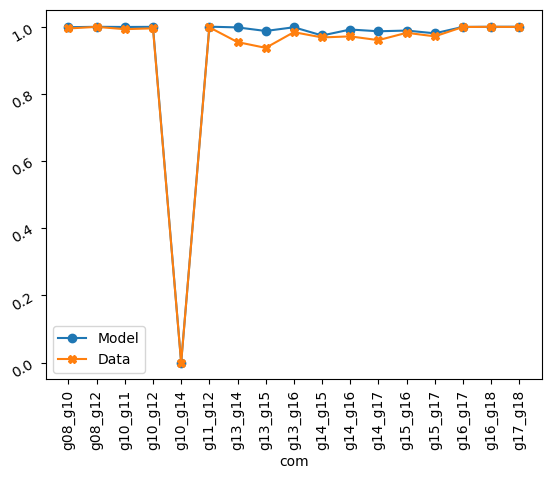

[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17.]
[Text(-1.0, 0, ''), Text(0.0, 0, 'g08_g10'), Text(1.0, 0, 'g08_g12'), Text(2.0, 0, 'g10_g11'), Text(3.0, 0, 'g10_g12'), Text(4.0, 0, 'g10_g14'), Text(5.0, 0, 'g11_g12'), Text(6.0, 0, 'g13_g14'), Text(7.0, 0, 'g13_g15'), Text(8.0, 0, 'g13_g16'), Text(9.0, 0, 'g14_g15'), Text(10.0, 0, 'g14_g16'), Text(11.0, 0, 'g14_g17'), Text(12.0, 0, 'g15_g16'), Text(13.0, 0, 'g15_g17'), Text(14.0, 0, 'g16_g17'), Text(15.0, 0, 'g16_g18'), Text(16.0, 0, 'g17_g18'), Text(17.0, 0, '')]


In [34]:
dd = fit_par['dat'] == 'xrsb_flux'

a = fit_par[dd].plot(x='com',y=['r2','dr2'],label=['Model','Data'],style=['o-','X-'])
a.xaxis.set_major_locator(ticker.MultipleLocator(1))
a.set_xticklabels(['']+ list(fit_par[dd]['com']),rotation=90)
plt.yticks(rotation=30) 
a.tick_params(axis='x', labelrotation=90)
plt.show()

print(a.get_xticks())
print(a.get_xticklabels())
    

In [ ]:

np.linalg.lstsq(ol_df[ol_col[0]].to_numpy().reshape(ol_df.shape[0],1), ol_df[ol_col[1]])